In [20]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from DiagnosisAI.datasets_torch.chest_dataset import ChestDataset
from DiagnosisAI.lightining_modules.chest_model import ChestModel
import torch as t
from tqdm import tqdm
import torch.nn as nn
import pickle
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from DiagnosisAI.utils.metrics import calculate_type_errors, calc_metrics
from sklearn.manifold import TSNE
import cv2
from sklearn.decomposition import PCA
import matplotlib
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [21]:
logs = pd.read_csv('../trainings/logs/chest/metricsCrossEntropyRes18.csv')
logs = logs.groupby('epoch').mean()
metrics_cols = ['train_Precision', 'train_Recall', 'train_F1Score',
       'train_Accuracy',
       'val_Precision', 'val_Recall', 'val_F1Score', 'val_Accuracy']
logs[metrics_cols] = logs[metrics_cols] * 100

In [23]:
log_train_loss = logs['train_loss']
log_val_loss = logs['val_loss']
epochs = np.arange(1, len(log_val_loss) + 1)

Text(0, 0.5, 'Wartość binarnej entropii krzyżowej')

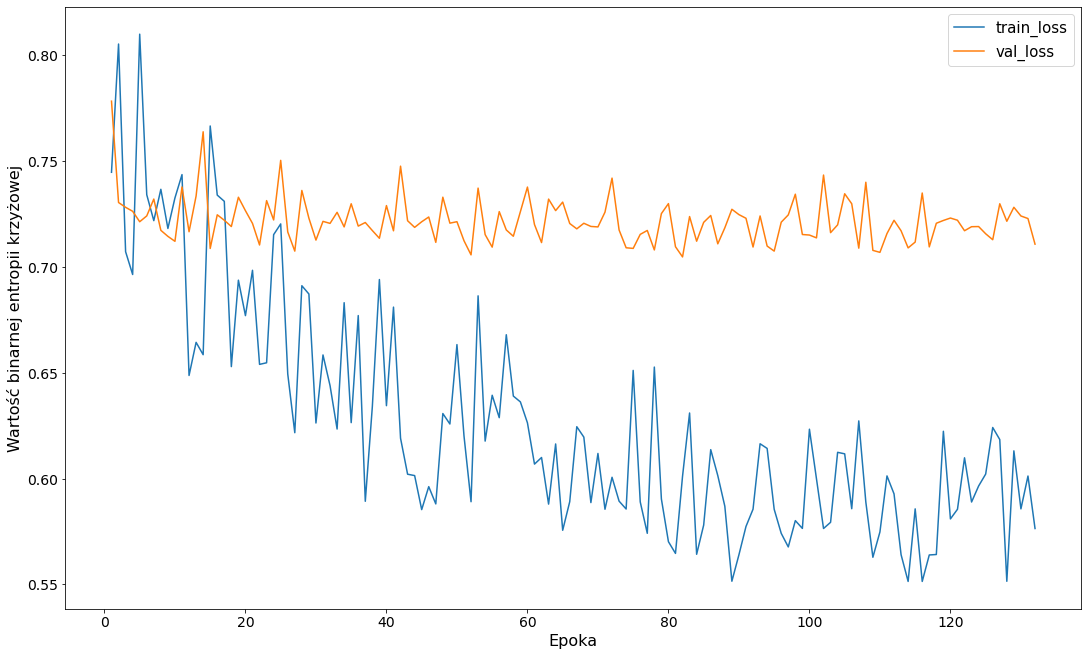

In [24]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(15, 9), constrained_layout=True)

ax.plot(epochs, log_train_loss)
ax.plot(epochs, log_val_loss)
ax.legend(["train_loss", "val_loss"], loc=0, prop={'size': 15})
ax.set_xlabel('Epoka', size=16)
ax.set_ylabel('Wartość binarnej entropii krzyżowej', size=16)

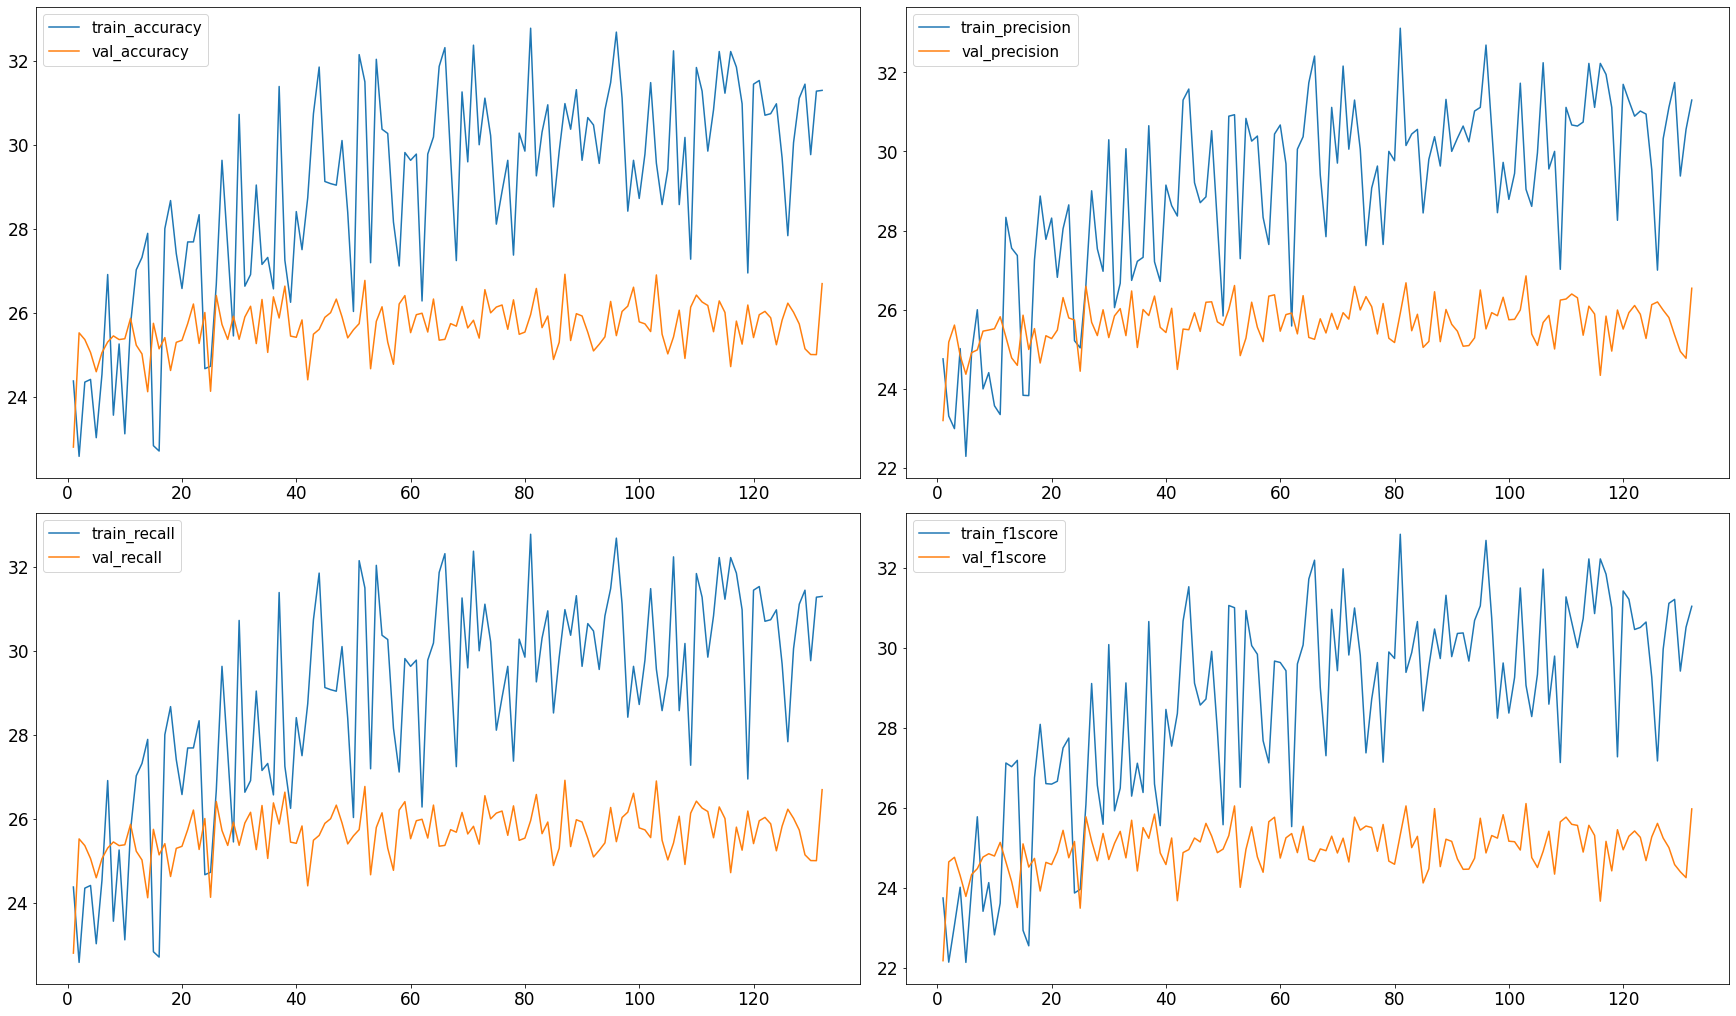

In [25]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(24, 14), constrained_layout=True)
spec = fig.add_gridspec(2, 2)
ax00 = fig.add_subplot(spec[0, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax10 = fig.add_subplot(spec[1, 0], sharex=ax00)
ax11 = fig.add_subplot(spec[1, 1], sharex=ax01)
ax00.plot(epochs, logs['train_Accuracy'])
ax00.plot(epochs, logs['val_Accuracy'])
ax00.legend(['train_accuracy', 'val_accuracy'], loc=0, prop={'size': 15})
ax01.plot(epochs, logs['train_Precision'])
ax01.plot(epochs, logs['val_Precision'])
ax01.legend(['train_precision', 'val_precision'], loc=0, prop={'size': 15})
ax10.plot(epochs, logs['train_Recall'])
ax10.plot(epochs, logs['val_Recall'])
ax10.legend(['train_recall', 'val_recall'], loc=0, prop={'size': 15})
ax11.plot(epochs, logs['train_F1Score'])
ax11.plot(epochs, logs['val_F1Score'])
ax11.legend(['train_f1score', 'val_f1score'], loc=0, prop={'size': 15})


READ DATASET

In [35]:
chest_path = Path("../datasets/chest_xray/")
model_path = Path('../trainings/model_states/chest_models/checkpoint_model_state18.ckpt')

In [28]:
normal_filenames = []
virus_filenames = []
bacteria_filenames = []

for dirs in chest_path.iterdir():
  dir_name = str(dirs)
  for filenames in dirs.iterdir():
    if "NORMAL" in dir_name:
      normal_filenames.append(filenames)
    if "VIRUS" in dir_name:
      virus_filenames.append(filenames)
    if "BACTERIA" in dir_name:
      bacteria_filenames.append(filenames)
len(normal_filenames), len(virus_filenames), len(bacteria_filenames)

(1583, 1493, 2780)

In [29]:
# normal split
train_n_filenames, rest_n_filenames = train_test_split(normal_filenames, test_size=0.3, random_state=42)
valid_n_filenames, test_n_filenames = train_test_split(rest_n_filenames, test_size=0.5, random_state=42)

# virus split
train_v_filenames, rest_v_filenames = train_test_split(virus_filenames, test_size=0.3, random_state=42)
valid_v_filenames, test_v_filenames = train_test_split(rest_v_filenames, test_size=0.5, random_state=42)

# bacteria split
train_b_filenames, rest_b_filenames = train_test_split(bacteria_filenames, test_size=0.3, random_state=42)
valid_b_filenames, test_b_filenames = train_test_split(rest_b_filenames, test_size=0.5, random_state=42)

In [30]:
# 0 - normal
# 1 - bacteria
# 2 - virus

train_filenames = train_n_filenames + train_b_filenames + train_v_filenames
train_classes = np.full(len(train_n_filenames), 0).tolist() + np.full(len(train_b_filenames), 1).tolist() + np.full(len(train_v_filenames), 2).tolist()
valid_filenames = valid_n_filenames + valid_b_filenames + valid_v_filenames
valid_classes = np.full(len(valid_n_filenames), 0).tolist() + np.full(len(valid_b_filenames), 1).tolist() + np.full(len(valid_v_filenames), 2).tolist()
test_filenames = test_n_filenames + test_b_filenames + test_v_filenames
test_classes = np.full(len(test_n_filenames), 0).tolist() + np.full(len(test_b_filenames), 1).tolist() + np.full(len(test_v_filenames), 2).tolist()

len(train_filenames), len(valid_filenames), len(test_filenames), len(train_classes), len(valid_classes), len(test_classes)

(4099, 878, 879, 4099, 878, 879)

In [31]:
train_dataset = ChestDataset(train_filenames, train_classes)
valid_dataset = ChestDataset(valid_filenames, valid_classes)
test_dataset = ChestDataset(test_filenames, test_classes)

In [32]:
batch_size = 8
train_chest_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_chest_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_chest_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

EVAL

In [36]:
chest_model = ChestModel()

In [37]:
from torchvision.models import resnet18

In [ ]:
network = chest_model.network
network.load_state_dict(t.load(model_path, map_location=t.device('cpu')))

In [43]:
network = resnet18()
network.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
network = nn.Sequential(
                        network,
                        nn.Linear(in_features=1000, out_features=3))

network.load_state_dict(t.load(model_path, map_location=t.device('cpu')))

<All keys matched successfully>

In [45]:
network.eval()
global_tp = 0
global_fp = 0
global_tn = 0
global_fn = 0
accs = 0.0
recalls = 0.0
f1scores = 0.0
precisions = 0.0
cmatrix_all = 0
for i, (inputs, labels) in enumerate(tqdm(test_chest_dataloader), 0):
    with t.no_grad():        
        outputs = network(inputs.type(t.float32))
    outputs = nn.Softmax(dim=1)(outputs)
    labels = nn.functional.one_hot(labels.type(t.int64), num_classes=3)
    # labels = labels.squeeze()

    pred_classes = t.argmax(outputs, dim=1)
    target_classes = t.argmax(labels, dim=1)

    tp, fp, tn, fn = calculate_type_errors(pred_classes, target_classes, mode='classif_multiclass', num_classes=3)
    cmatrix = confusion_matrix(target_classes, pred_classes, labels=[0, 1, 2])
    cmatrix_all += cmatrix
    global_tp += tp.numpy()
    global_fp += fp.numpy()
    global_tn += tn.numpy()
    global_fn += fn.numpy()

    # accs += Accuracy()(pred_classes, target_classes).item()
    # recalls += Recall()(pred_classes, target_classes).item()
    # precisions += Precision()(pred_classes, target_classes).item()
    # f1scores += F1Score()(pred_classes, target_classes).item()

# calc metrics
recall, precision, acc, f1_score = calc_metrics(global_tp, global_fp, global_tn, global_fn)

print(f"Recall: {recall}, Precision: {precision}, Acc: {acc}, F1_score: {f1_score}")
# print(f"Metrics acc: {accs / (i+1)}, Recalls: {recalls / (i+1)}, Prec: {precisions / (i+1)}, f1: {f1scores / (i+1)}")

100%|██████████| 110/110 [00:43<00:00,  2.55it/s]

Recall: [[1.        ]
 [0.95203837]
 [0.87053571]], Precision: [[0.97142857]
 [0.93853428]
 [0.92417062]], Acc: [[0.99203641]
 [0.9476678 ]
 [0.94880546]], F1_score: [[0.98550725]
 [0.9452381 ]
 [0.89655172]]


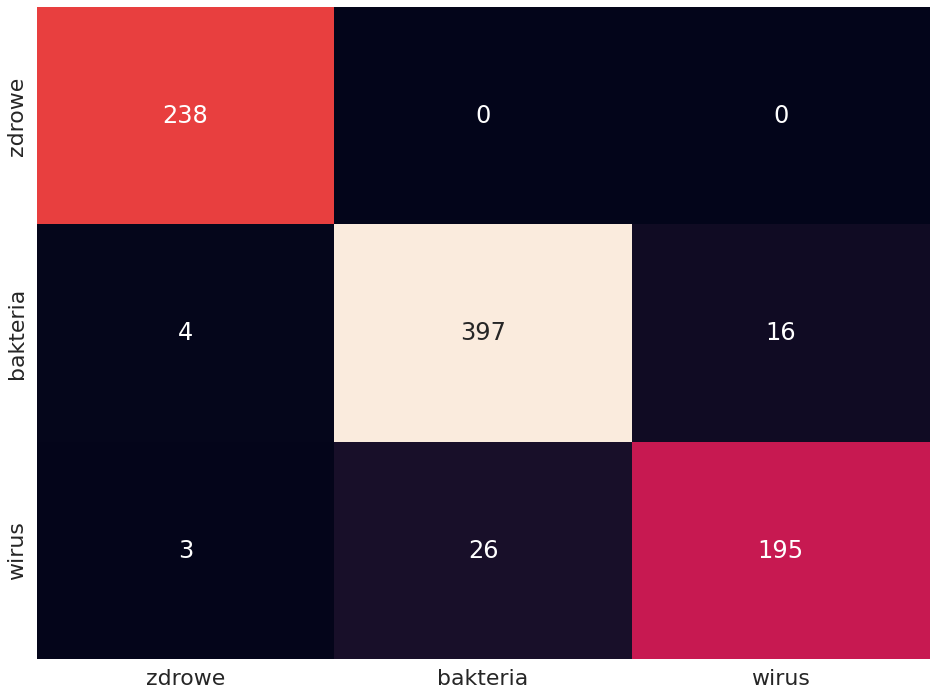

In [54]:
fig, ax  = plt.subplots(figsize=(16, 12))
labels = ['zdrowe', 'bakteria', 'wirus']
df_cm = pd.DataFrame(cmatrix_all, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=False, fmt='g')
sns.set(font_scale=2)

In [14]:
df_cm,

(          zdrowe  bakteria  wirus
 zdrowe       230         3      5
 bakteria       2       373     42
 wirus          0        33    191,)

In [14]:
print(f"Recall: {recall.mean()}, Precision: {precision.mean()}, Acc: {acc.mean()}, F1_score: {f1_score.mean()}")

Recall: 0.9045165128401479, Precision: 0.9019602529486628, Acc: 0.9355328024270003, F1_score: 0.9029036436176718


In [12]:
global_tp.sum(), global_fp.sum(), global_tn.sum(), global_fn.sum()

(794, 85, 1673, 85)

EMBEDDINGS

In [26]:
embedd_network = [module for module in list(network.modules())[0]][0]
embedd_network = nn.Sequential(*list(embedd_network.children())[:-1])

In [27]:
embedd_network.eval() # przełączenie modelu do testowania
emb_labels = []
embeddings = []
emb_filenames = []
for i, (inputs, labels) in enumerate(tqdm(test_dataset), 0):
    with t.no_grad():
        outputs = embedd_network(inputs.unsqueeze(0).type(t.float32))
        embeddings.append(outputs.squeeze().numpy())
        emb_labels.append(labels.squeeze().item())
        emb_filenames.append(test_dataset.filenames[i])

embeddings = np.array(embeddings)

100%|██████████| 879/879 [04:00<00:00,  3.66it/s]


In [28]:
emb_info = {'embeddings': embeddings, 'emb_filenames': emb_filenames, 'emb_labels': emb_labels}

In [29]:
with open('../embeddings/extracted_features_chest_resnet50', 'wb') as handle:
    pickle.dump(emb_info, handle)

In [30]:
# load embeddings and info
with open('../embeddings/extracted_features_chest_resnet50', 'rb') as handle:
    emb_info = pickle.load(handle)

emb_filenames = emb_info['emb_filenames']
emb_labels = emb_info['emb_labels']
embeddings = emb_info['embeddings']

EVAL EMBEDDINGS

In [40]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean', random_state=42).fit_transform(embeddings)
pca_results = PCA(n_components=2).fit_transform(embeddings)

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 879 samples in 0.005s...
[t-SNE] Computed neighbors for 879 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 879 / 879
[t-SNE] Mean sigma: 1.612791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.203075
[t-SNE] KL divergence after 1000 iterations: 0.633257


PCA, TSNE

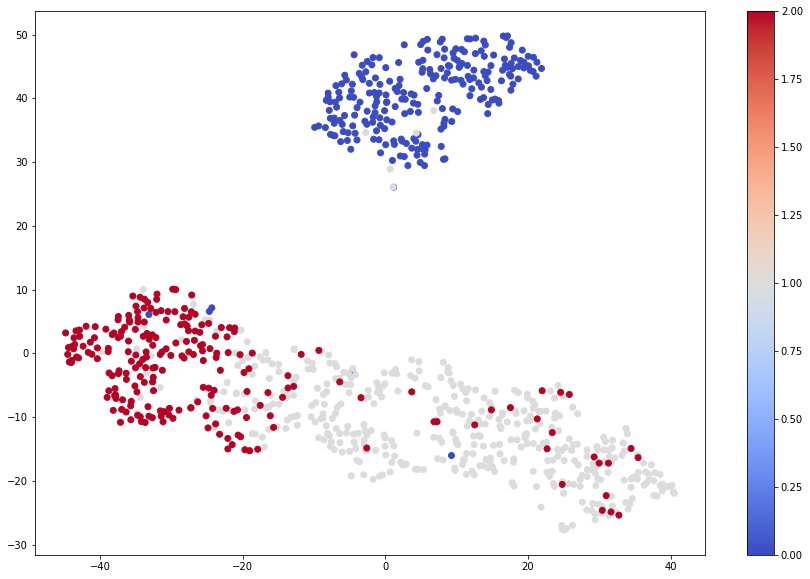

In [38]:
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=emb_labels,cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()

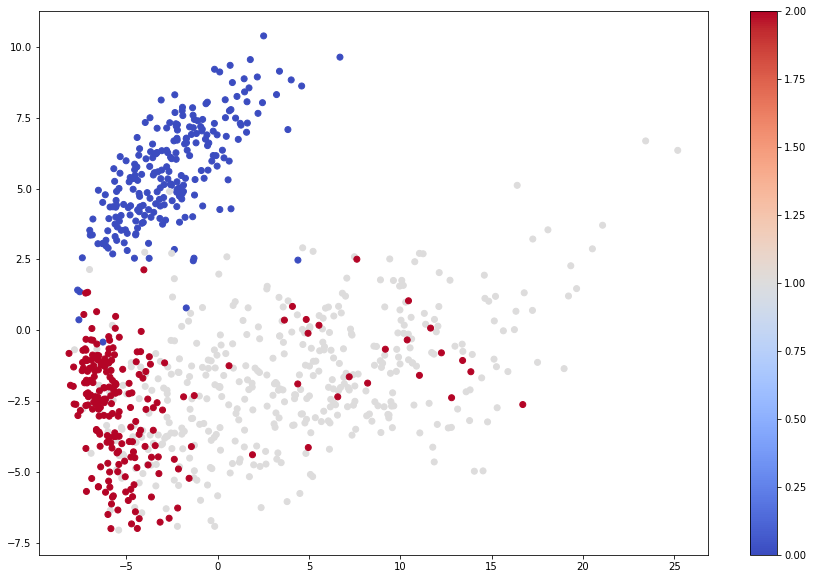

In [41]:
plt.figure(figsize=(15, 10))
plt.scatter(pca_results[:,0],pca_results[:,1], c=emb_labels,cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()

SEARCHING

In [75]:
map_labels = {0: 'NORMAL', 1: 'BACTERIA', 2: 'VIRUS'}

In [126]:
query_idx = 700
neighbors = NearestNeighbors(n_neighbors=len(embeddings), algorithm='brute', metric='euclidean').fit(embeddings)
distances, indices = neighbors.kneighbors([embeddings[query_idx]])

indices = indices.flatten()

k_nearest = indices[0:5]
nearest_dist = distances.flatten()[0:5].round(2)
k_furthest = indices[-5:][::-1]
furthest_dist = distances.flatten()[-5:][::-1].round(2)

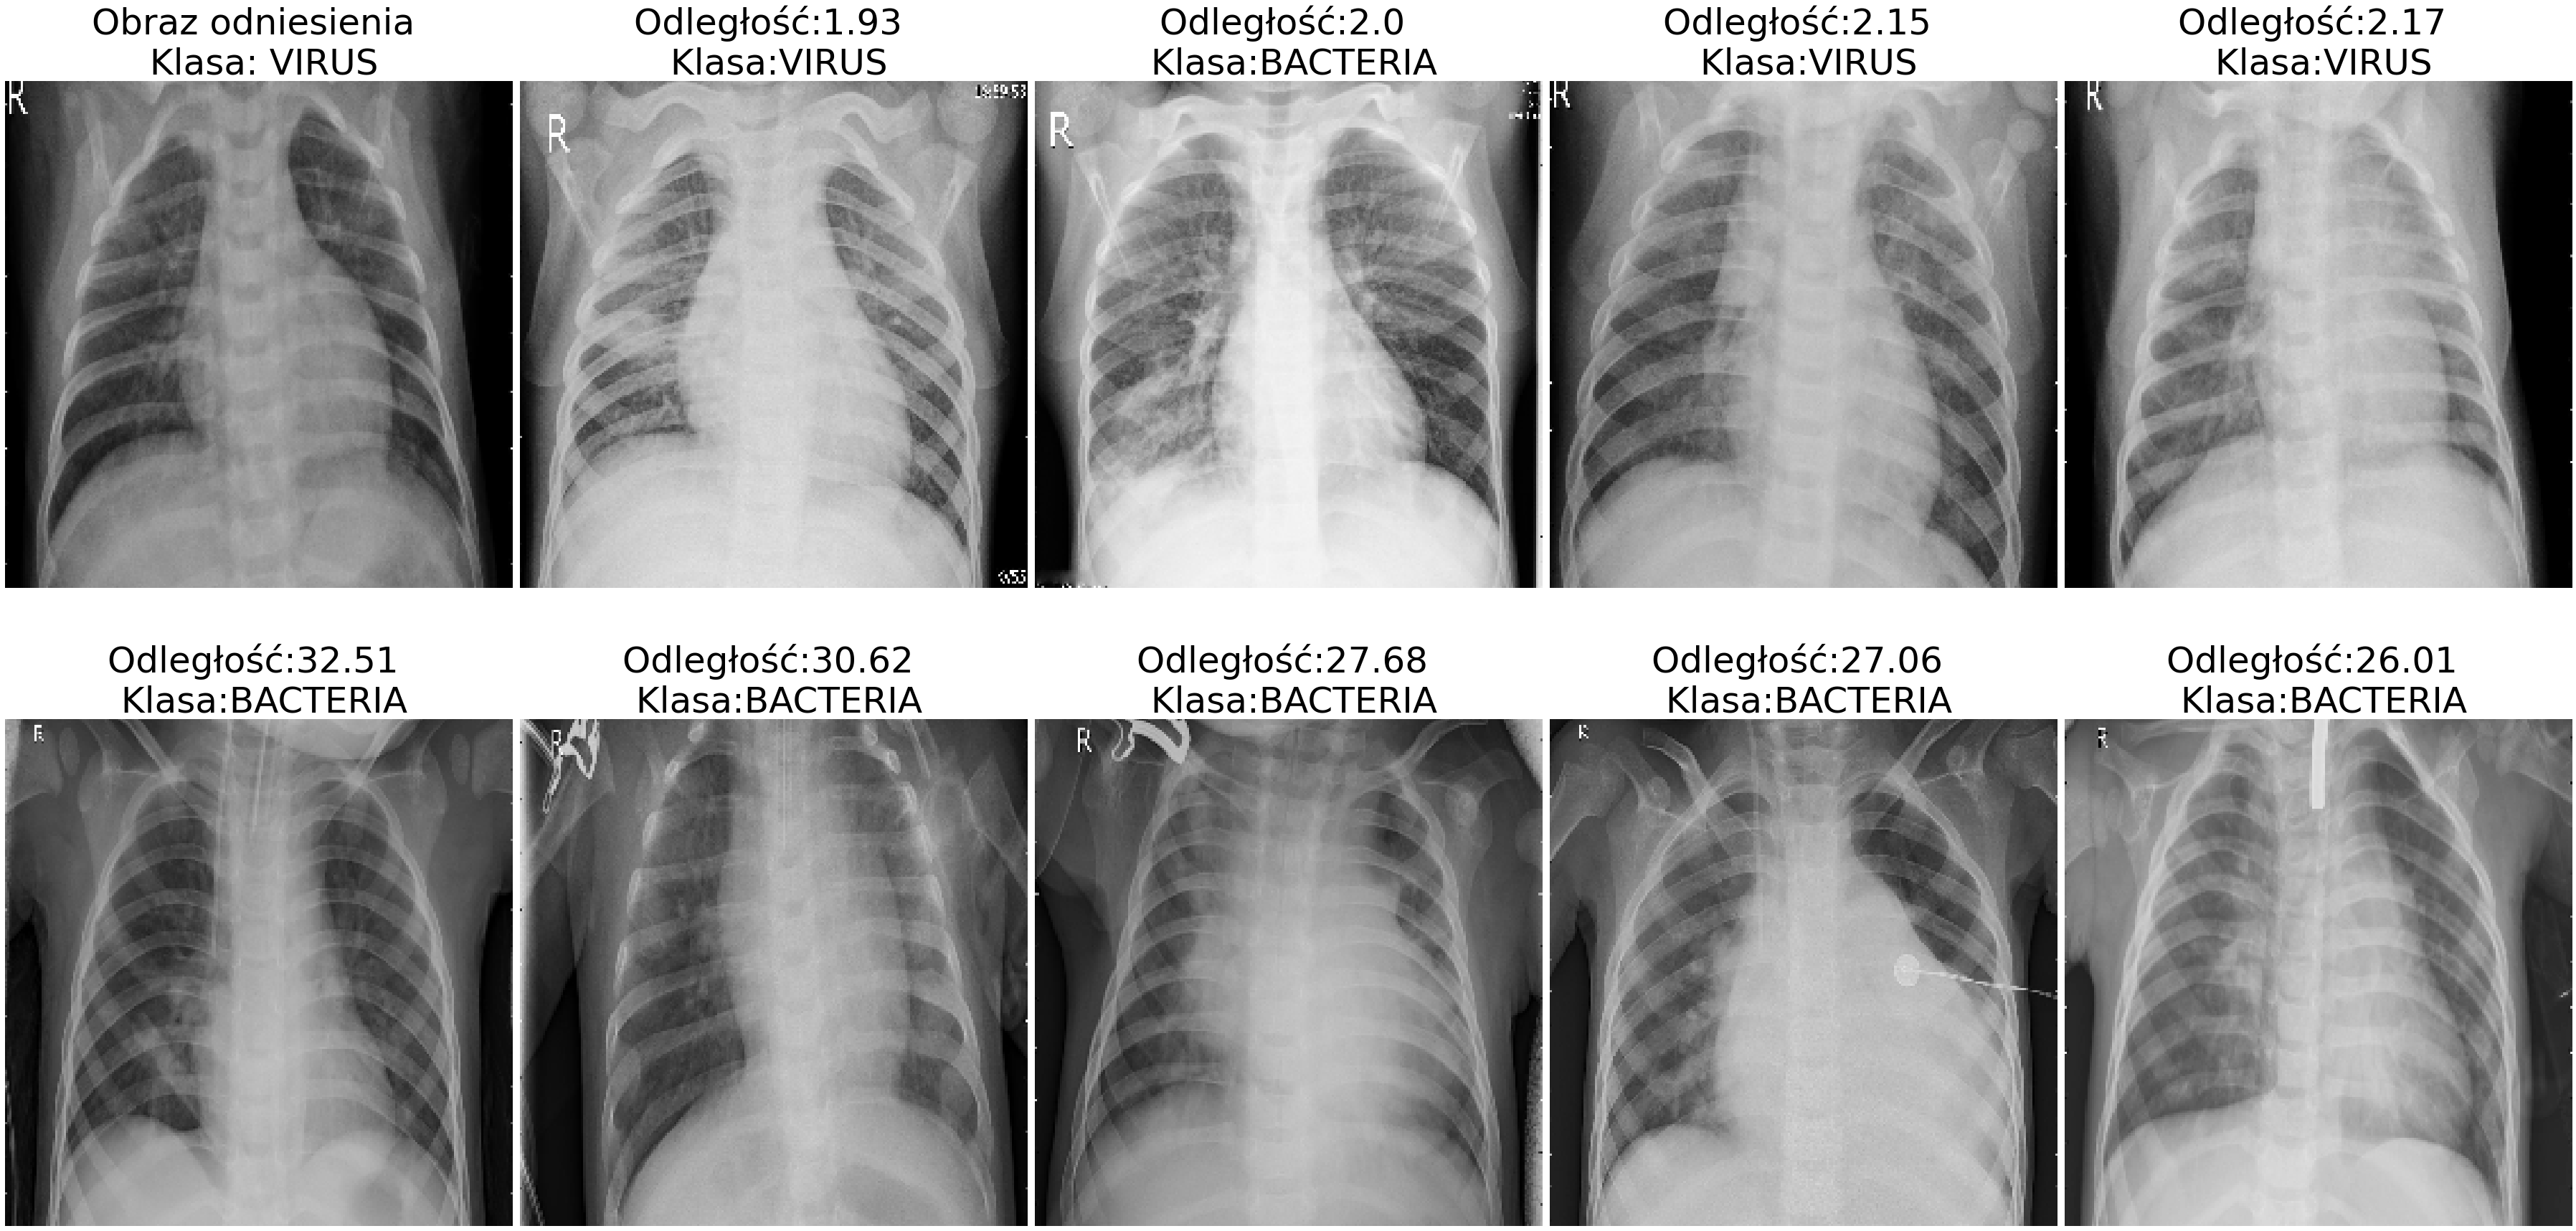

In [127]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 26))
for i, idx in enumerate(k_nearest):
    img = cv2.imread(str(emb_filenames[idx]), cv2.IMREAD_GRAYSCALE)
    img  = cv2.resize(img, (224, 224))
    ax[0, i].imshow(img, cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(nearest_dist.tolist()[i], 2)} \n Klasa:{map_labels[emb_labels[idx]]}', size=50)
    ax[0, i].axis('off')
ax[0, 0].set_title(f'Obraz odniesienia \n Klasa: {map_labels[emb_labels[query_idx]]}', size=50)

for i, idx in enumerate(k_furthest):
    img = cv2.imread(str(emb_filenames[idx]), cv2.IMREAD_GRAYSCALE)
    img  = cv2.resize(img, (224, 224))
    ax[1, i].imshow(img, cmap='gray')
    ax[1, i].set_title(f'Odległość:{round(furthest_dist.tolist()[i], 2)} \n Klasa:{map_labels[emb_labels[idx]]}', size=50)
    ax[1, i].axis('off')

fig.tight_layout()

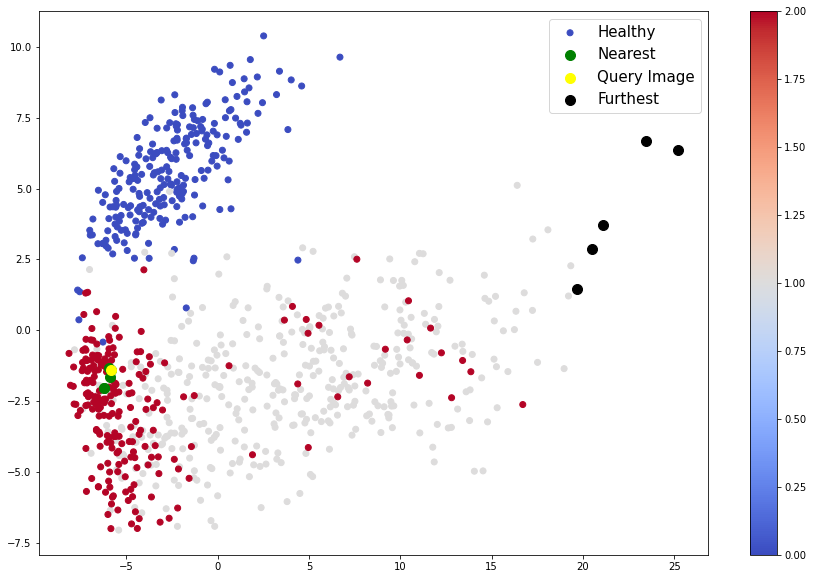

In [128]:
# PCA VIS
plt.figure(figsize=(15, 10))
plt.scatter(pca_results[:,0],pca_results[:,1], c=emb_labels,cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()
plt.scatter(pca_results[k_nearest,0],pca_results[k_nearest,1], c='green', s=100)
plt.scatter(pca_results[query_idx,0],pca_results[query_idx,1], c='yellow', s=100)
plt.scatter(pca_results[k_furthest,0],pca_results[k_furthest,1], c='black', s=100)
plt.legend(['Healthy', 'Nearest', 'Query Image', 'Furthest'],  loc=0, prop={'size': 15})